## Imports

In [1]:
import os
import sys
sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

np.random.seed(1234)
plt.style.use('default')

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Fold 2

In [2]:
cluster = '17'
fold = '0'
peak = 'overlap'
gwas = 'Nalls'

## Prepare Reference Alleles

In [3]:
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 5


## Prepare Alternate Alleles

In [4]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 5


## Find Alternate Alleles that Break Accessibility

In [5]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
2,2,chr1,171711151,171711152,rs12119232,13,A,C,2.451195,2.405438,-0.045756
3,3,chr1,205719531,205719532,rs823114,15,G,A,1.735617,1.712290,-0.023327
4,4,chr1,232660039,232660040,rs2182431,19,A,G,0.764758,0.902451,0.137693
0,0,chr1,155108166,155108167,rs12726330,11,G,A,1.172484,1.318016,0.145532
1,1,chr1,155108166,155108167,rs12726330,11,G,C,1.172484,1.368876,0.196391


## Get 10 bp around SNP

In [6]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(major_seqs[idx][490:510])
    print(major_seqs[idx][490:500], '|', major_seqs[idx][500:510])

GGGGGAGACAGTTGGTGCGG
GGGGGAGACA | GTTGGTGCGG
AGAGCGCACGGCCGCAAAAC
AGAGCGCACG | GCCGCAAAAC
TGAAGTTAAAACAATAGTAT
TGAAGTTAAA | ACAATAGTAT
TCTGGACCAGGGTACTGGGA
TCTGGACCAG | GGTACTGGGA
TCTGGACCAGGGTACTGGGA
TCTGGACCAG | GGTACTGGGA


## Visualize Top Sequences

Index:  2  Importance:  2.45119466  RSID:  rs12119232   chr1 : 171711151 - 171711152  Locus:  13
Major Allele:  A


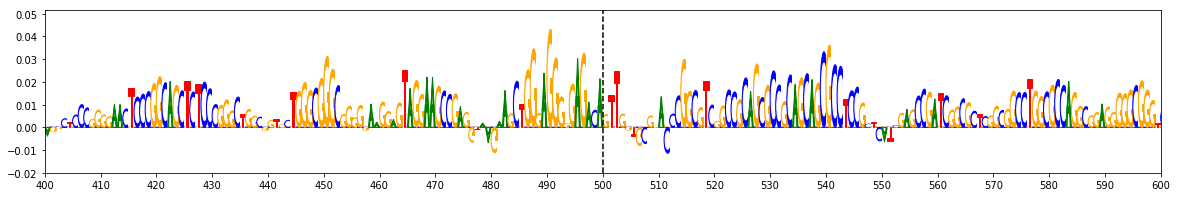

Index:  2  Importance:  2.405438456  RSID:  rs12119232
Minor Allele:  C


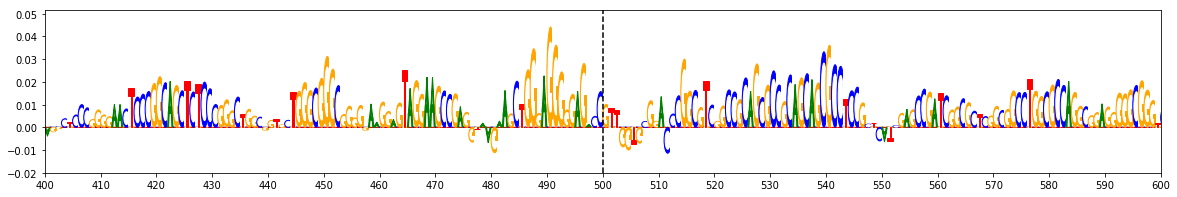

Index:  2  Delta:  -0.04575620399999991  RSID:  rs12119232
Minor - Major:  C - A


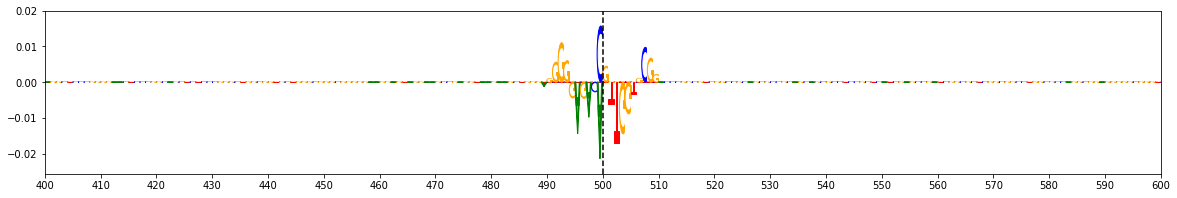

In [7]:
for idx in seq_df.iloc[:1]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [7]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
14,14,chr3,49044766,49044767,rs6781790,59,T,C,1.229649,1.834236,0.604587
10,10,chr3,48778026,48778027,rs6442130,59,G,A,0.593696,0.841900,0.248203
1,1,chr3,122135254,122135255,rs55911744,53,T,G,1.526851,1.760888,0.234037
16,16,chr3,49045354,49045355,rs13316620,59,C,G,0.954367,1.140658,0.186290
15,15,chr3,49045354,49045355,rs13316620,59,C,T,0.954367,1.064524,0.110157
7,7,chr3,161090615,161090616,rs2054710,55,C,G,0.298628,0.357702,0.059073
12,12,chr3,48956861,48956862,rs9884022,59,C,T,0.930858,0.924396,-0.006462
8,8,chr3,161090615,161090616,rs2054710,55,C,T,0.298628,0.275600,-0.023028
11,11,chr3,48956861,48956862,rs9884022,59,C,G,0.930858,0.907268,-0.023589
6,6,chr3,161051792,161051793,rs11718905,55,G,A,-0.174384,-0.203026,-0.028641


## Get 10 bp around SNP

In [8]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(minor_seqs[idx][490:510])
    print(minor_seqs[idx][490:500], '|', major_seqs[idx][500:510])

AGCTGAGGGCGCTGTTGATG
AGCTGAGGGC | GCTGTTGATG
TGTTTCAGCAGCCTTCCCCA
TGTTTCAGCA | GCCTTCCCCA
GCCCACACCGGACGCGTAAG
GCCCACACCG | GACGCGTAAG
GGGCCGAGCGGGGGGGGGCG
GGGCCGAGCG | GGGGGGGGCG
GGGCCGAGCTGGGGGGGGCG
GGGCCGAGCT | GGGGGGGGCG


## Visualize Top Sequences

Index:  14  Importance:  1.834236492  RSID:  rs6781790 chr3 :  49044766  -  49044767  Locus:  59
Minor Allele:  C


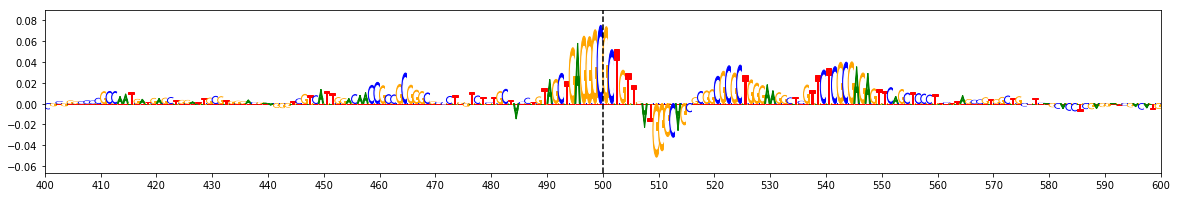

Index:  14  Importance:  1.2296490085  RSID:  rs6781790
Major Allele:  T


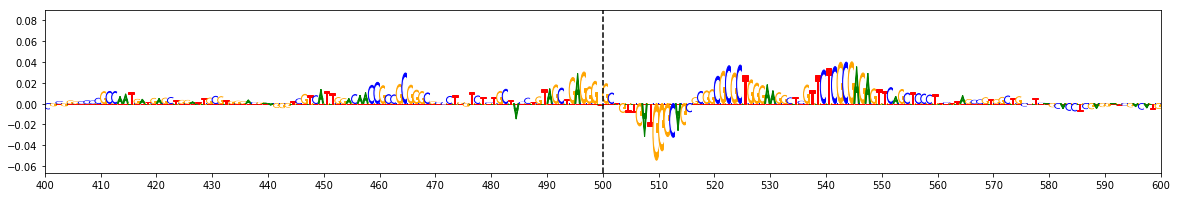

Index:  14  Delta:  0.6045874835  RSID:  rs6781790
Minor - Major:  C - T


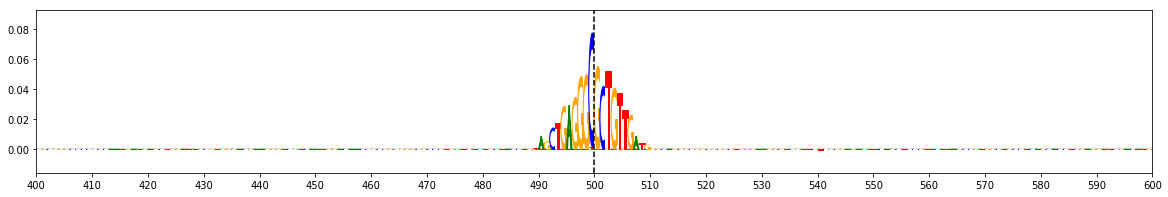

In [9]:
for idx in seq_df.iloc[:1]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

# Fold 6

## Prepare Reference Alleles

In [39]:
cluster = '24'
fold = '6'
peak = 'overlap'
gwas = 'Kunkle'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 1


## Prepare Alternate Alleles

In [40]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 1


## Find Alternate Alleles that Break Accessibility

In [41]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
0,0,chr7,143107875,143107876,rs11762262,160,C,T,0.583746,0.514458,-0.069288


## Get 10 bp around SNP

In [42]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(major_seqs[idx][490:510])
    print(major_seqs[idx][490:500], '|', major_seqs[idx][500:510])

TCTGACACACATTGCTCTGC
TCTGACACAC | ATTGCTCTGC


## Visualize Top Sequences

Index:  0  Importance:  0.5837461271  RSID:  rs11762262   chr7 : 143107875 - 143107876  Locus:  160
Major Allele:  C


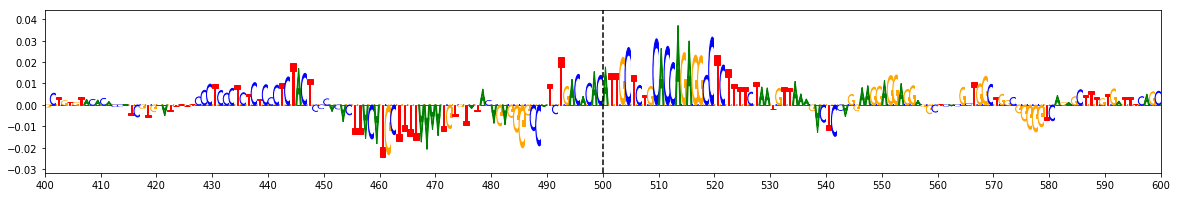

Index:  0  Importance:  0.5144582294000001  RSID:  rs11762262
Minor Allele:  T


KeyboardInterrupt: 

In [ ]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [31]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
20,20,chr11,60019149,60019150,rs636317,149,T,C,1.656542,3.299272,1.642730
40,40,chr11,85867874,85867875,rs10792832,150,G,A,1.094689,1.470480,0.375790
17,17,chr11,59988861,59988862,rs584469,149,T,G,1.705030,2.043117,0.338087
39,39,chr11,85852978,85852979,rs10792831,150,A,G,2.363931,2.701221,0.337290
0,0,chr11,47398962,47398963,rs12146565,148,G,A,-0.392465,-0.069623,0.322842
1,1,chr11,47399601,47399602,rs2278890,148,G,A,0.433770,0.662054,0.228284
26,26,chr11,60031398,60031399,rs10736700,149,C,T,0.172574,0.367345,0.194772
3,3,chr11,47416635,47416636,rs55876153,148,G,C,0.170297,0.362318,0.192021
27,27,chr11,60031398,60031399,rs10736700,149,C,A,0.172574,0.356640,0.184066
7,7,chr11,47429903,47429904,rs7947450,148,G,A,3.067069,3.248758,0.181689


## Get 10 bp around SNP

In [32]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(minor_seqs[idx][490:510])
    print(minor_seqs[idx][490:500], '|', major_seqs[idx][500:510])

CTTTGCTGCCATCTGCTGGG
CTTTGCTGCC | ATCTGCTGGG
AAAATGTAGAAGCAAAACAT
AAAATGTAGA | AGCAAAACAT
CCCCATTCCGGCCACACTGC
CCCCATTCCG | GCCACACTGC
GGGGAACAGGAAGGTTGATC
GGGGAACAGG | AAGGTTGATC
GAAAAGGGAAAAGGGTCCTT
GAAAAGGGAA | AAGGGTCCTT


## Visualize Top Sequences

Index:  20  Importance:  1.6565424143  RSID:  rs636317 chr11 :  60019149  -  60019150  Locus:  149
Minor Allele:  C


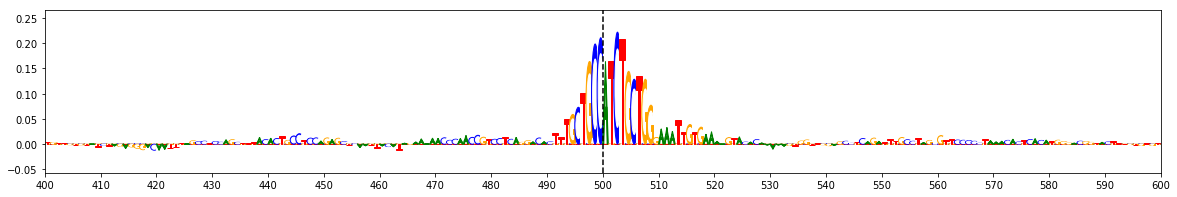

Index:  20  Importance:  1.6565424143  RSID:  rs636317
Major Allele:  T


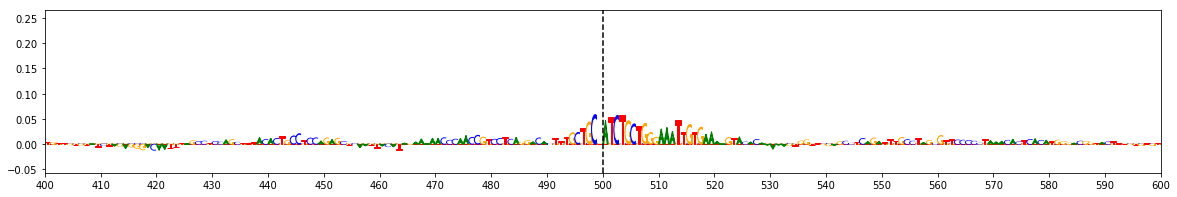

Index:  20  Delta:  1.6427298736999996  RSID:  rs636317
Minor - Major:  C - T


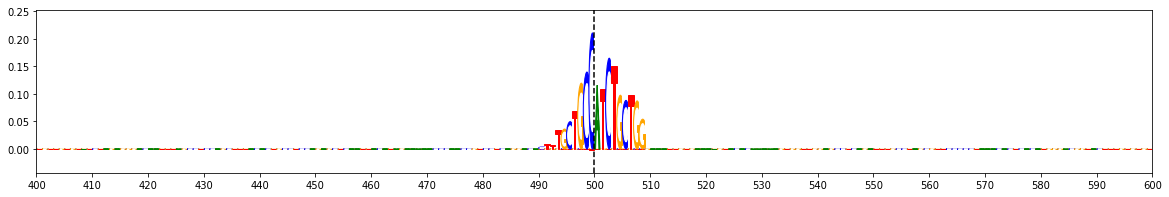

Index:  40  Importance:  1.0946893402  RSID:  rs10792832 chr11 :  85867874  -  85867875  Locus:  150
Minor Allele:  A


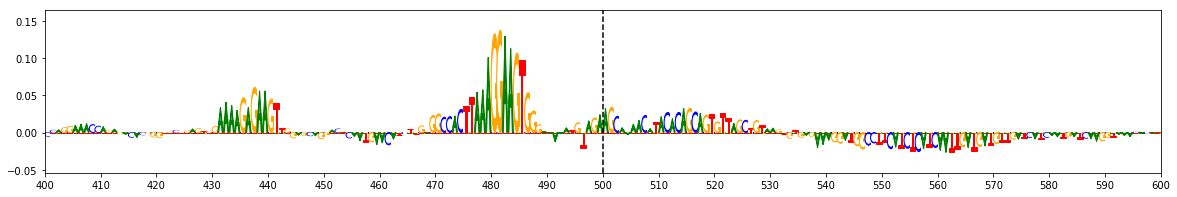

Index:  40  Importance:  1.0946893402  RSID:  rs10792832
Major Allele:  G


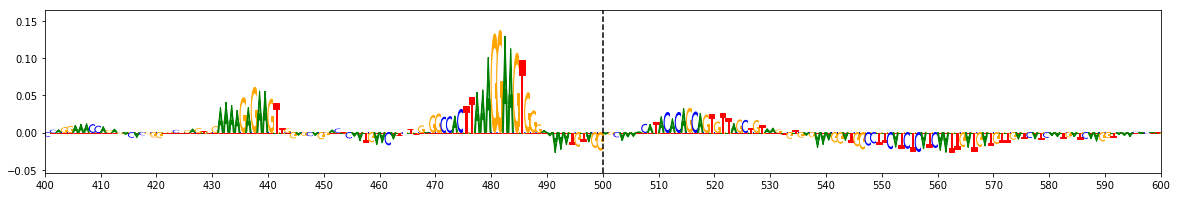

Index:  40  Delta:  0.3757902812  RSID:  rs10792832
Minor - Major:  A - G


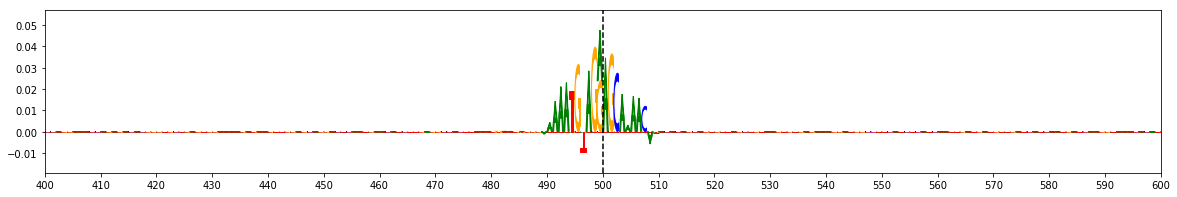

Index:  17  Importance:  1.7050295674000002  RSID:  rs584469 chr11 :  59988861  -  59988862  Locus:  149
Minor Allele:  G


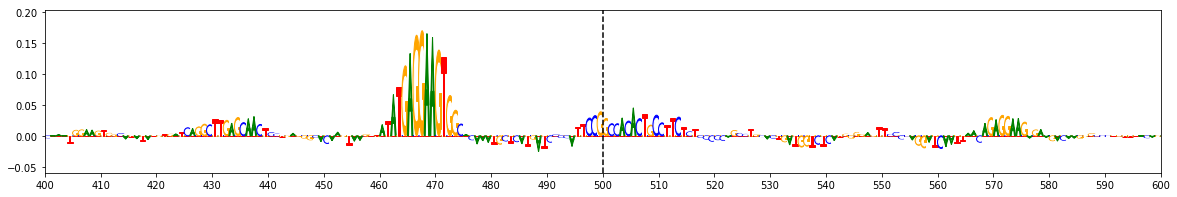

Index:  17  Importance:  1.7050295674000002  RSID:  rs584469
Major Allele:  T


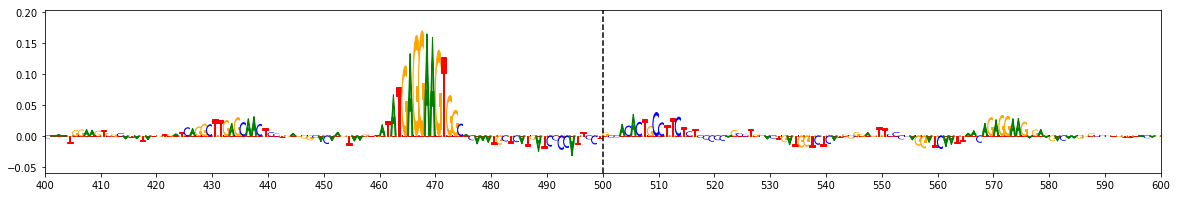

Index:  17  Delta:  0.3380872598999993  RSID:  rs584469
Minor - Major:  G - T


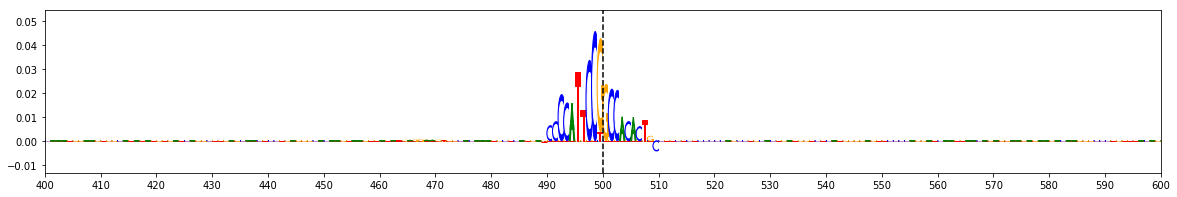

Index:  39  Importance:  2.3639307448  RSID:  rs10792831 chr11 :  85852978  -  85852979  Locus:  150
Minor Allele:  G


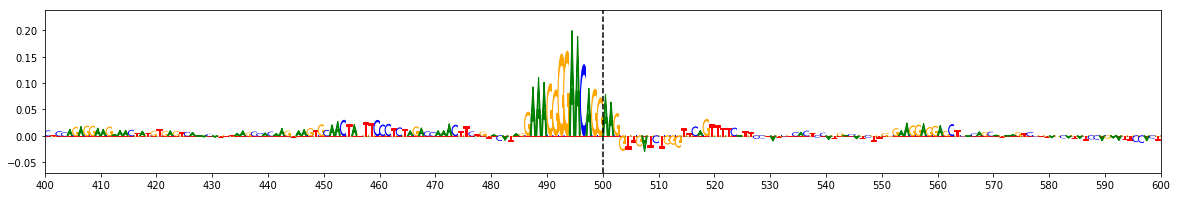

Index:  39  Importance:  2.3639307448  RSID:  rs10792831
Major Allele:  A


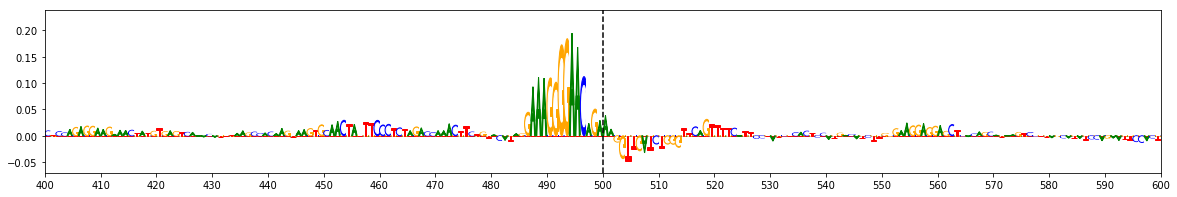

Index:  39  Delta:  0.3372900018999996  RSID:  rs10792831
Minor - Major:  G - A


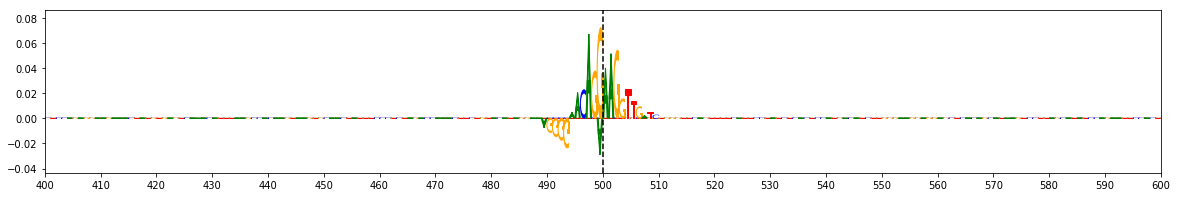

Index:  0  Importance:  -0.39246520100000004  RSID:  rs12146565 chr11 :  47398962  -  47398963  Locus:  148
Minor Allele:  A


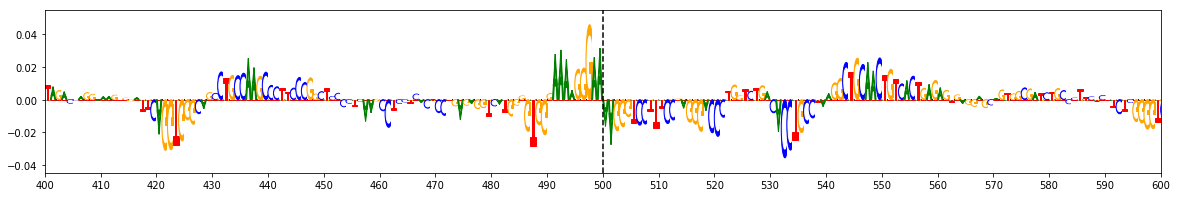

Index:  0  Importance:  -0.39246520100000004  RSID:  rs12146565
Major Allele:  G


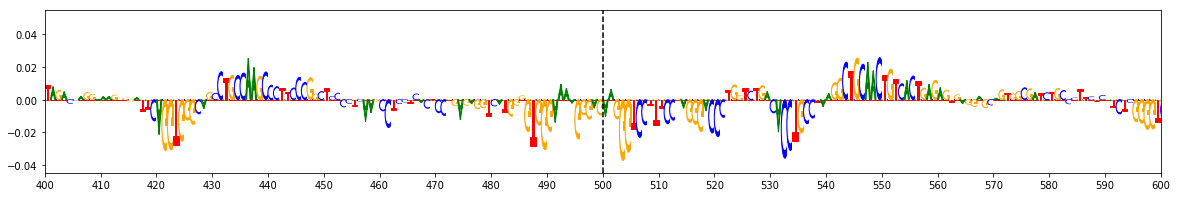

Index:  0  Delta:  0.322842067  RSID:  rs12146565
Minor - Major:  A - G


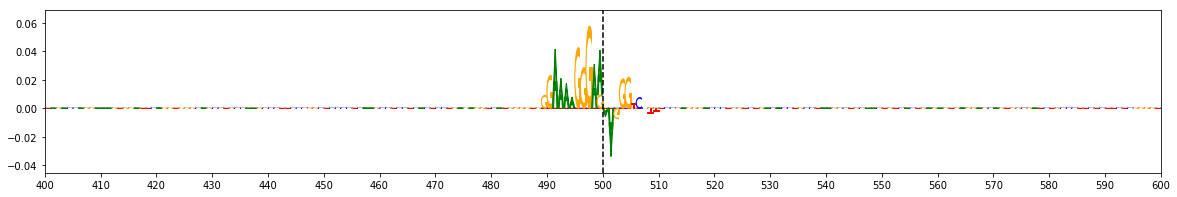

In [33]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

# Fold 9

## Prepare Reference Alleles

In [34]:
cluster = '24'
fold = '9'
peak = 'overlap'
gwas = 'Kunkle'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 3


## Prepare Alternate Alleles

In [35]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 3


## Find Alternate Alleles that Break Accessibility

In [36]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
1,1,chr8,27226789,27226790,rs755951,161,A,T,-0.594121,-0.681722,-0.087600
2,2,chr8,27456252,27456253,rs2279590,161,C,T,2.024471,2.291536,0.267065
0,0,chr8,27226789,27226790,rs755951,161,A,C,-0.594121,0.172130,0.766251


## Get 10 bp around SNP

In [37]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(major_seqs[idx][490:510])
    print(major_seqs[idx][490:500], '|', major_seqs[idx][500:510])

TTCACTGGCATGTAGGGGGA
TTCACTGGCA | TGTAGGGGGA
CCTCCTGCTCCTCCAAGGAA
CCTCCTGCTC | CTCCAAGGAA
TTCACTGGCATGTAGGGGGA
TTCACTGGCA | TGTAGGGGGA


## Visualize Top Sequences

Index:  1  Importance:  -0.5941214895000001  RSID:  rs755951   chr8 : 27226789 - 27226790  Locus:  161
Major Allele:  A


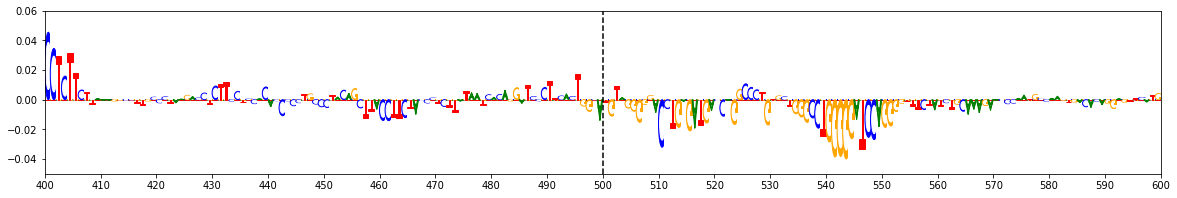

Index:  1  Importance:  -0.6817219513999999  RSID:  rs755951
Minor Allele:  T


KeyboardInterrupt: 

In [38]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [31]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
20,20,chr11,60019149,60019150,rs636317,149,T,C,1.656542,3.299272,1.642730
40,40,chr11,85867874,85867875,rs10792832,150,G,A,1.094689,1.470480,0.375790
17,17,chr11,59988861,59988862,rs584469,149,T,G,1.705030,2.043117,0.338087
39,39,chr11,85852978,85852979,rs10792831,150,A,G,2.363931,2.701221,0.337290
0,0,chr11,47398962,47398963,rs12146565,148,G,A,-0.392465,-0.069623,0.322842
1,1,chr11,47399601,47399602,rs2278890,148,G,A,0.433770,0.662054,0.228284
26,26,chr11,60031398,60031399,rs10736700,149,C,T,0.172574,0.367345,0.194772
3,3,chr11,47416635,47416636,rs55876153,148,G,C,0.170297,0.362318,0.192021
27,27,chr11,60031398,60031399,rs10736700,149,C,A,0.172574,0.356640,0.184066
7,7,chr11,47429903,47429904,rs7947450,148,G,A,3.067069,3.248758,0.181689


## Get 10 bp around SNP

In [32]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(minor_seqs[idx][490:510])
    print(minor_seqs[idx][490:500], '|', major_seqs[idx][500:510])

CTTTGCTGCCATCTGCTGGG
CTTTGCTGCC | ATCTGCTGGG
AAAATGTAGAAGCAAAACAT
AAAATGTAGA | AGCAAAACAT
CCCCATTCCGGCCACACTGC
CCCCATTCCG | GCCACACTGC
GGGGAACAGGAAGGTTGATC
GGGGAACAGG | AAGGTTGATC
GAAAAGGGAAAAGGGTCCTT
GAAAAGGGAA | AAGGGTCCTT


## Visualize Top Sequences

Index:  20  Importance:  1.6565424143  RSID:  rs636317 chr11 :  60019149  -  60019150  Locus:  149
Minor Allele:  C


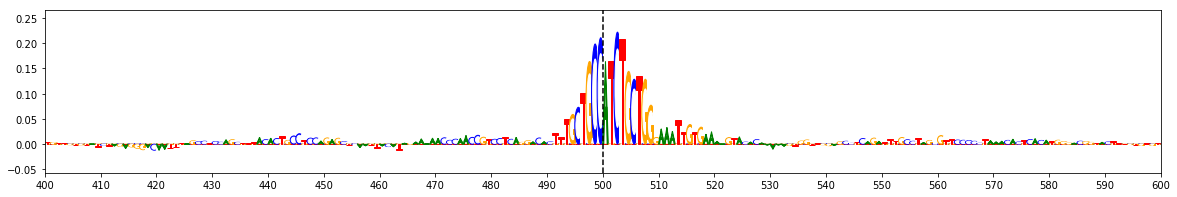

Index:  20  Importance:  1.6565424143  RSID:  rs636317
Major Allele:  T


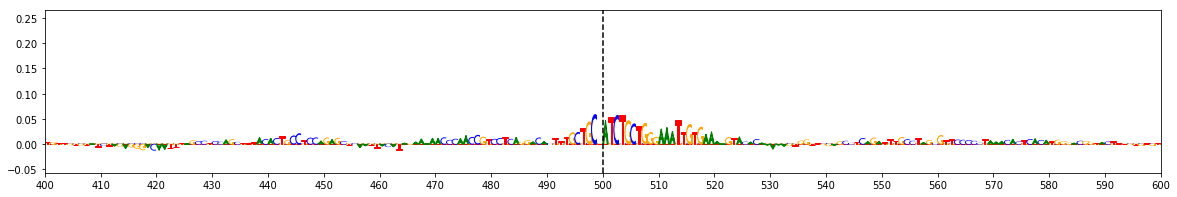

Index:  20  Delta:  1.6427298736999996  RSID:  rs636317
Minor - Major:  C - T


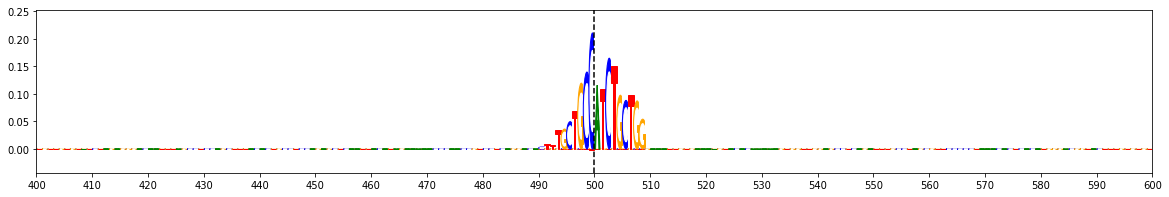

Index:  40  Importance:  1.0946893402  RSID:  rs10792832 chr11 :  85867874  -  85867875  Locus:  150
Minor Allele:  A


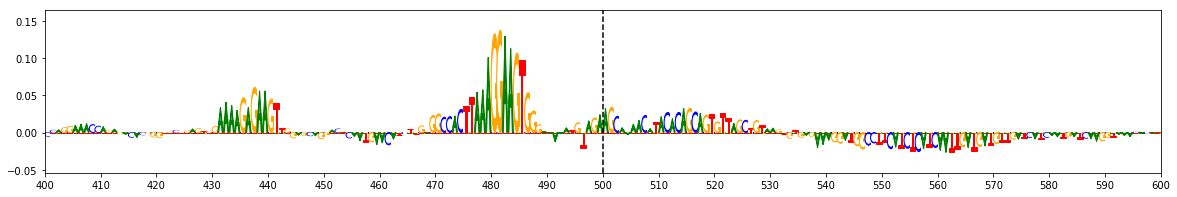

Index:  40  Importance:  1.0946893402  RSID:  rs10792832
Major Allele:  G


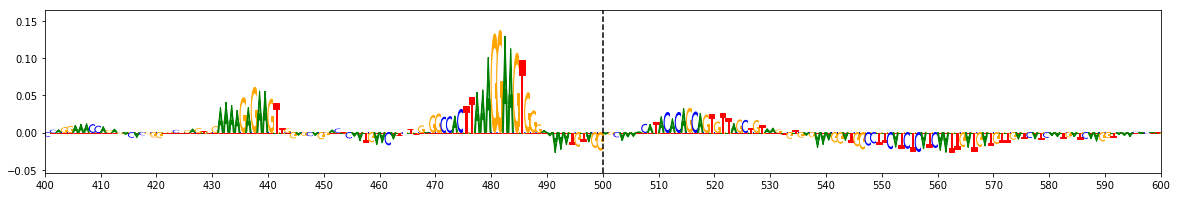

Index:  40  Delta:  0.3757902812  RSID:  rs10792832
Minor - Major:  A - G


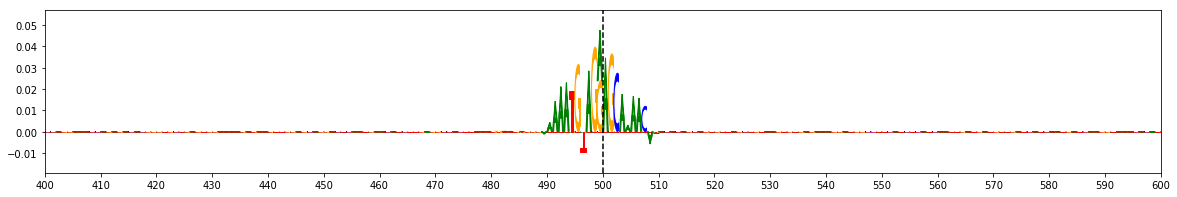

Index:  17  Importance:  1.7050295674000002  RSID:  rs584469 chr11 :  59988861  -  59988862  Locus:  149
Minor Allele:  G


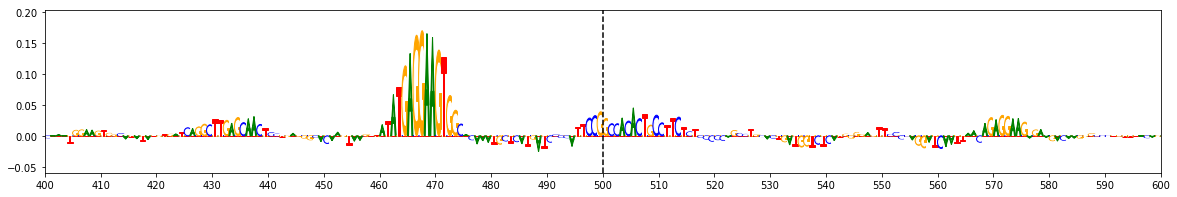

Index:  17  Importance:  1.7050295674000002  RSID:  rs584469
Major Allele:  T


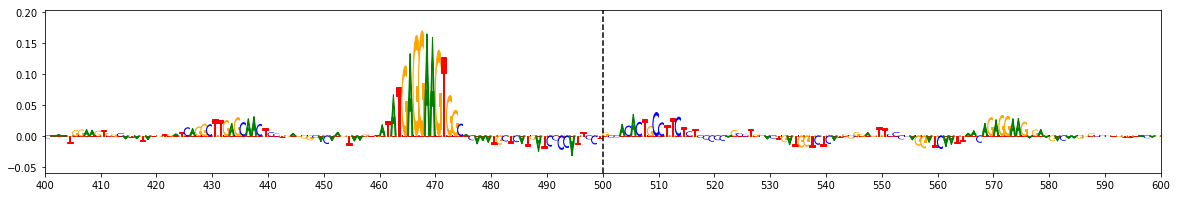

Index:  17  Delta:  0.3380872598999993  RSID:  rs584469
Minor - Major:  G - T


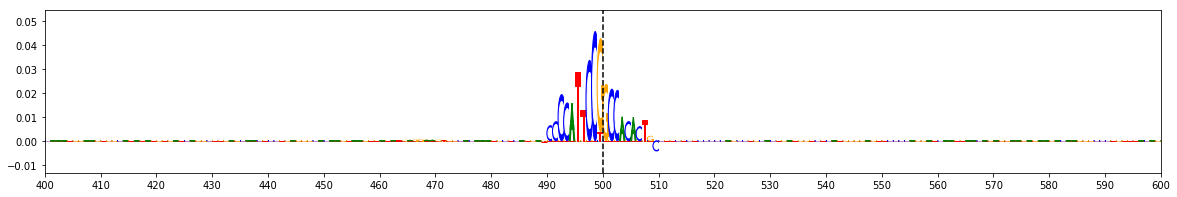

Index:  39  Importance:  2.3639307448  RSID:  rs10792831 chr11 :  85852978  -  85852979  Locus:  150
Minor Allele:  G


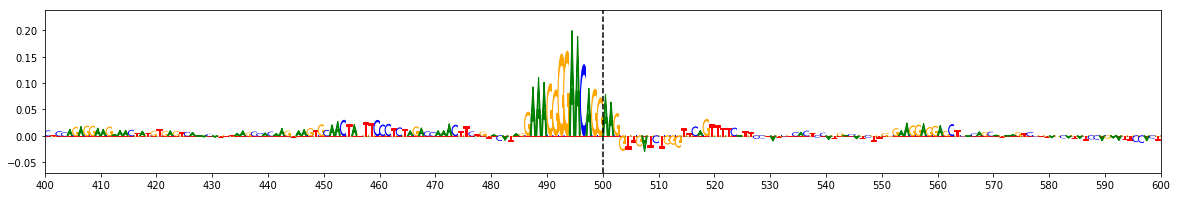

Index:  39  Importance:  2.3639307448  RSID:  rs10792831
Major Allele:  A


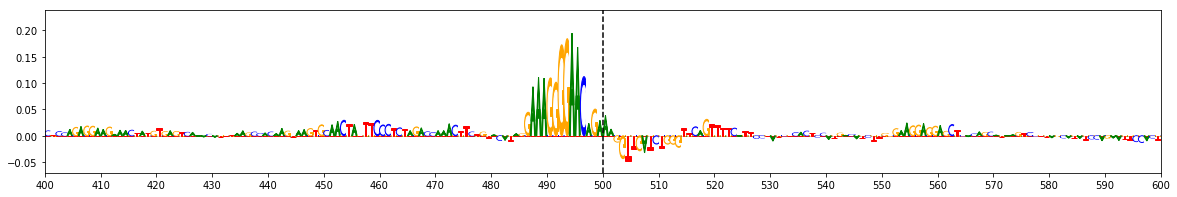

Index:  39  Delta:  0.3372900018999996  RSID:  rs10792831
Minor - Major:  G - A


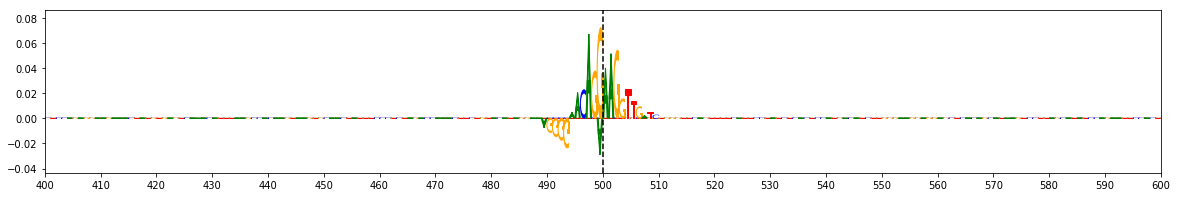

Index:  0  Importance:  -0.39246520100000004  RSID:  rs12146565 chr11 :  47398962  -  47398963  Locus:  148
Minor Allele:  A


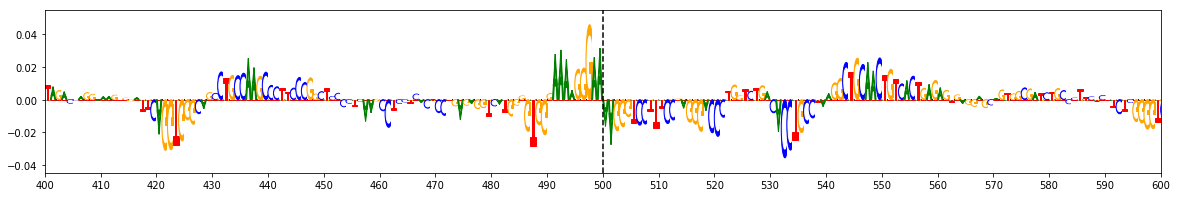

Index:  0  Importance:  -0.39246520100000004  RSID:  rs12146565
Major Allele:  G


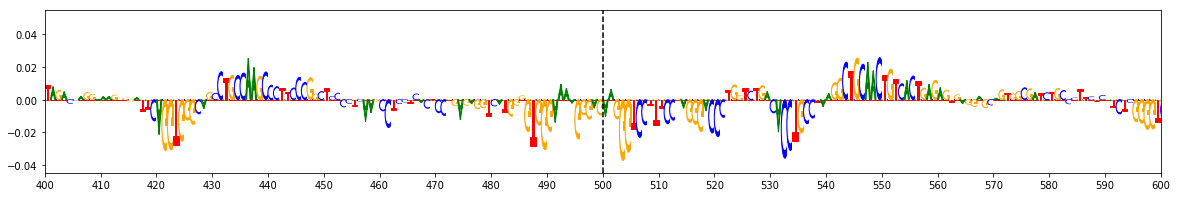

Index:  0  Delta:  0.322842067  RSID:  rs12146565
Minor - Major:  A - G


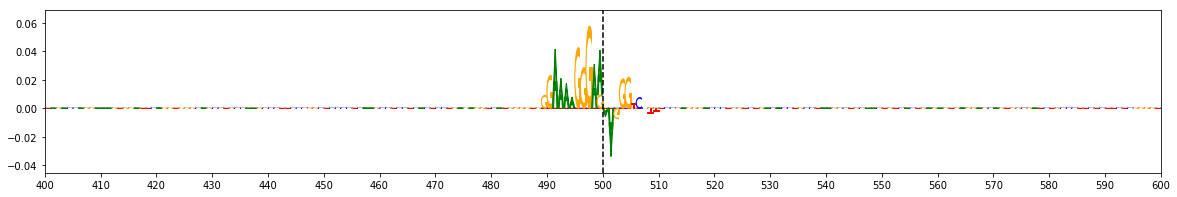

In [33]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

# Fold 7

## Prepare Reference Alleles

In [16]:
cluster = '24'
fold = '7'
peak = 'overlap'
gwas = 'Kunkle'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.txt', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_locus = gwas_bed[5].to_list()
gwas_major = gwas_bed[6].tolist()
gwas_minor = gwas_bed[7].tolist()

major_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.major.fasta'
major_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_major_hyp_scores.txt'

major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs if ('N' not in x)]

print("Num onehot sequences:", len(major_onehot))

major_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(major_hyp_file)], major_seqs) if 'N' not in w[1]]

major_imp_scores = get_impscores(major_hyp_scores, major_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(major_imp_scores,
                                 major_onehot,
                                 major_hyp_scores)])) == 0

major_normed_imp_scores, major_normed_hyp_scores = normalize_scores(
    impscores=major_imp_scores, hyp_impscores=major_hyp_scores, onehot_data=major_onehot)

Num onehot sequences: 41


## Prepare Alternate Alleles

In [17]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/gwas/'+peak+'/'+gwas+'.minor.fasta'
minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/clusters_gkmsvm/Cluster'+cluster+'/fold'+fold+'/explain/output/'+gwas+'_'+peak+'_minor_hyp_scores.txt'
                                                                                
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1]       
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                                 
                                                                                
minor_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(minor_hyp_file)], minor_seqs) if 'N' not in w[1]]                 
                                                                                
minor_imp_scores = get_impscores(minor_hyp_scores, minor_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(minor_imp_scores,                                
                                 minor_onehot,                                    
                                 minor_hyp_scores)])) == 0                        
                                                                                
minor_normed_imp_scores, minor_normed_hyp_scores = normalize_scores(                
    impscores=minor_imp_scores, hyp_impscores=minor_hyp_scores, onehot_data=minor_onehot)

Num onehot sequences: 41


## Find Alternate Alleles that Break Accessibility

In [18]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'locus':[], 'major_allele':[], 'minor_allele':[], 'major_score':[], 'minor_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['locus'].append(gwas_locus[i])
    seq_dict['major_allele'].append(gwas_major[i])
    seq_dict['minor_allele'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(major_imp_scores[i][400:600]))
    seq_dict['minor_score'].append(np.sum(minor_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(minor_imp_scores[i][400:600]) - np.sum(major_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
33,33,chr11,85779161,85779162,rs2509609,150,G,A,1.863188,1.282015,-0.581173
32,32,chr11,85779161,85779162,rs2509609,150,G,C,1.863188,1.345971,-0.517218
14,14,chr11,59951432,59951433,rs632185,149,G,A,1.649759,1.298187,-0.351572
19,19,chr11,60002934,60002935,rs718376,149,G,A,1.790668,1.539173,-0.251495
28,28,chr11,60031475,60031476,rs10736701,149,T,C,0.877373,0.644954,-0.232419
25,25,chr11,60031269,60031270,rs7128450,149,C,G,1.058709,0.840660,-0.218049
30,30,chr11,60078474,60078475,rs61900467,149,C,T,1.028374,0.843297,-0.185077
13,13,chr11,47902882,47902883,rs12364432,148,G,C,2.041510,1.858701,-0.182809
37,37,chr11,85828550,85828551,rs474479,150,G,C,1.476450,1.305661,-0.170789
24,24,chr11,60027308,60027309,rs1365247,149,C,T,2.836531,2.688468,-0.148063


## Get 10 bp around SNP

In [30]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(major_seqs[idx][490:510])
    print(major_seqs[idx][490:500], '|', major_seqs[idx][500:510])

AGGGATGGGGGAAGCAGCTA
AGGGATGGGG | GAAGCAGCTA
AGGGATGGGGGAAGCAGCTA
AGGGATGGGG | GAAGCAGCTA
CTGACTTCAGTGTATCAGGC
CTGACTTCAG | TGTATCAGGC
AGGACACTTGCAGTTTCATA
AGGACACTTG | CAGTTTCATA
GGACTGATCTTGTAACAAAG
GGACTGATCT | TGTAACAAAG


## Visualize Top Sequences

Index:  33  Importance:  1.8631882792  RSID:  rs2509609   chr11 : 85779161 - 85779162  Locus:  150
Major Allele:  G


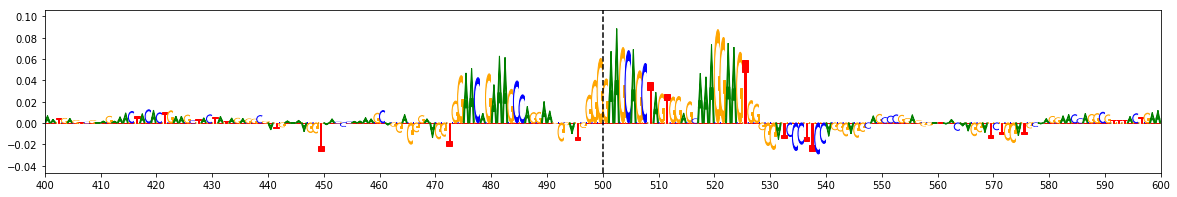

Index:  33  Importance:  1.2820154165000002  RSID:  rs2509609
Minor Allele:  A


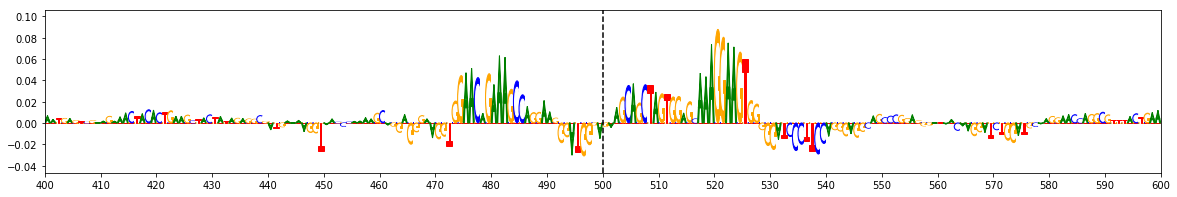

Index:  33  Delta:  -0.5811728626999999  RSID:  rs2509609
Minor - Major:  A - G


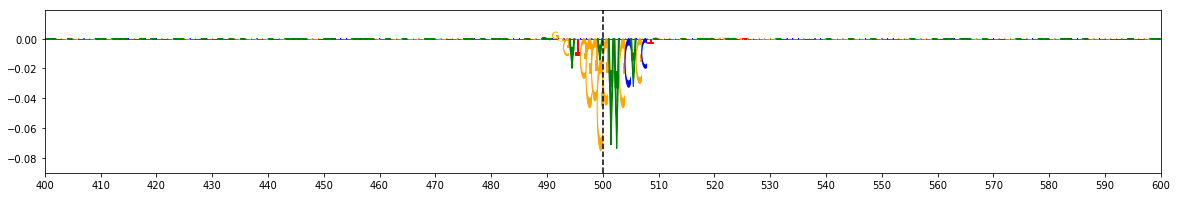

Index:  32  Importance:  1.8631882792  RSID:  rs2509609   chr11 : 85779161 - 85779162  Locus:  150
Major Allele:  G


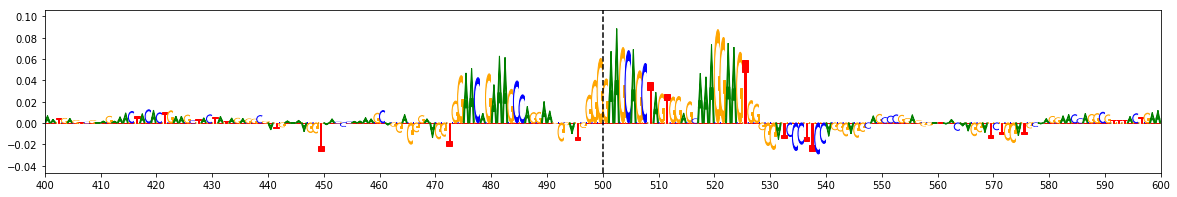

Index:  32  Importance:  1.3459706764  RSID:  rs2509609
Minor Allele:  C


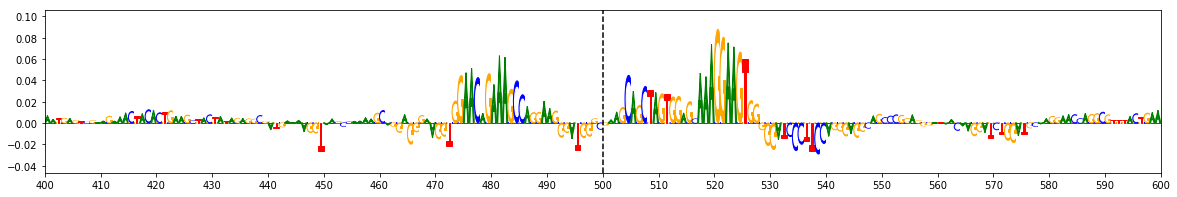

Index:  32  Delta:  -0.5172176028000002  RSID:  rs2509609
Minor - Major:  C - G


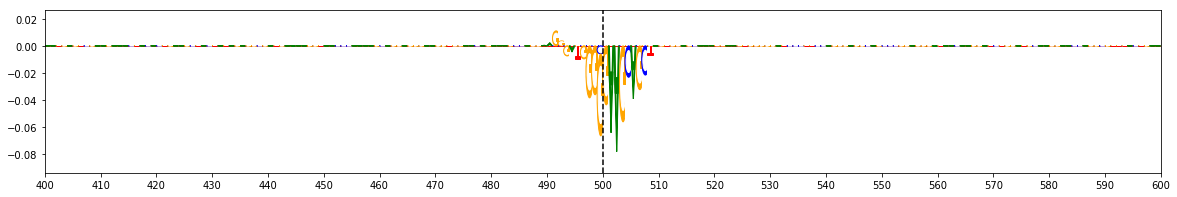

Index:  14  Importance:  1.6497586016  RSID:  rs632185   chr11 : 59951432 - 59951433  Locus:  149
Major Allele:  G


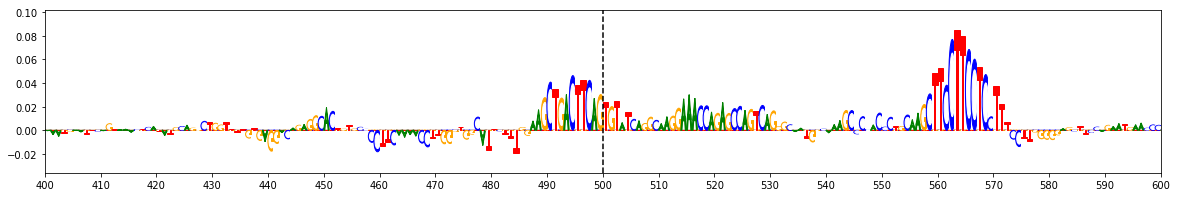

Index:  14  Importance:  1.2981870538  RSID:  rs632185
Minor Allele:  A


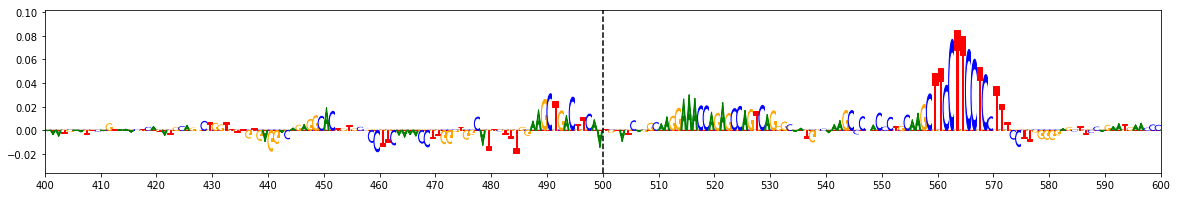

Index:  14  Delta:  -0.3515715478000001  RSID:  rs632185
Minor - Major:  A - G


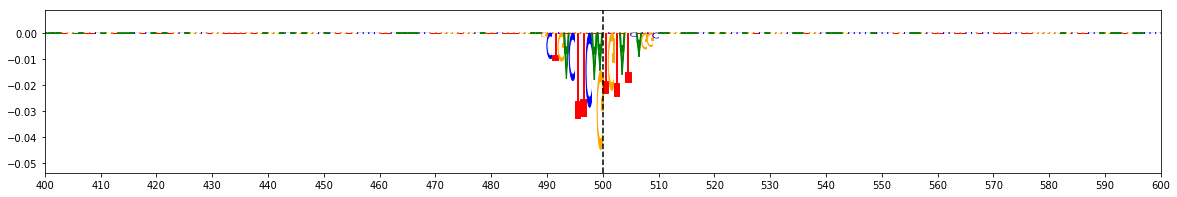

Index:  19  Importance:  1.7906678049999998  RSID:  rs718376   chr11 : 60002934 - 60002935  Locus:  149
Major Allele:  G


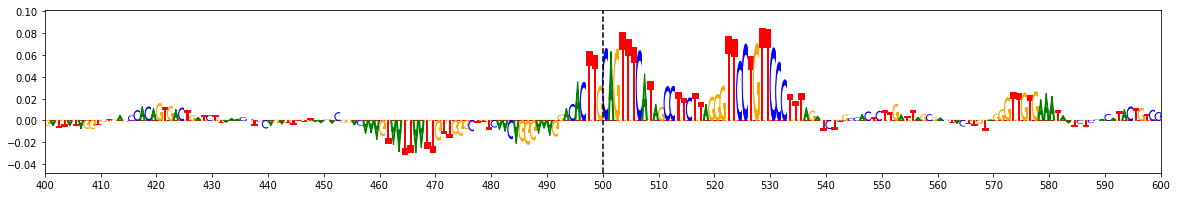

Index:  19  Importance:  1.5391732237999998  RSID:  rs718376
Minor Allele:  A


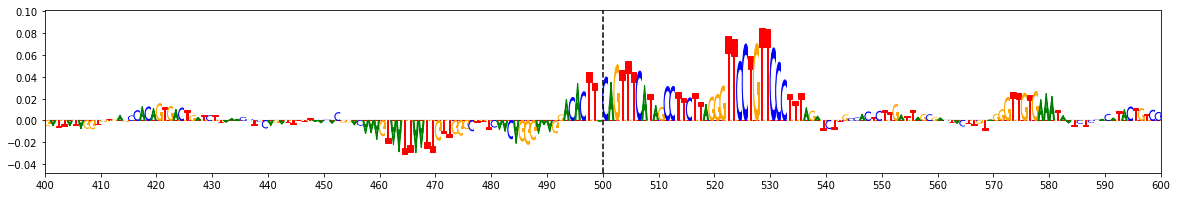

Index:  19  Delta:  -0.2514945812  RSID:  rs718376
Minor - Major:  A - G


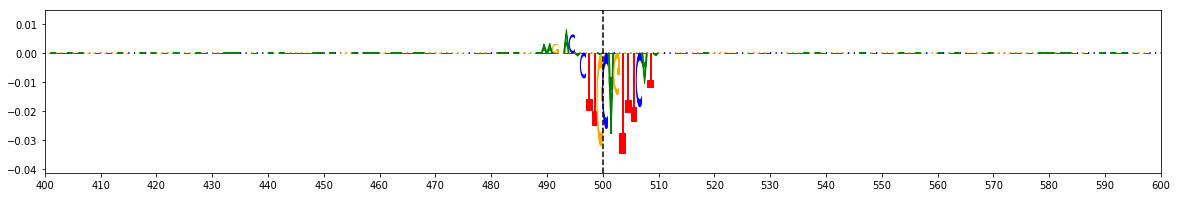

Index:  28  Importance:  0.8773725320000001  RSID:  rs10736701   chr11 : 60031475 - 60031476  Locus:  149
Major Allele:  T


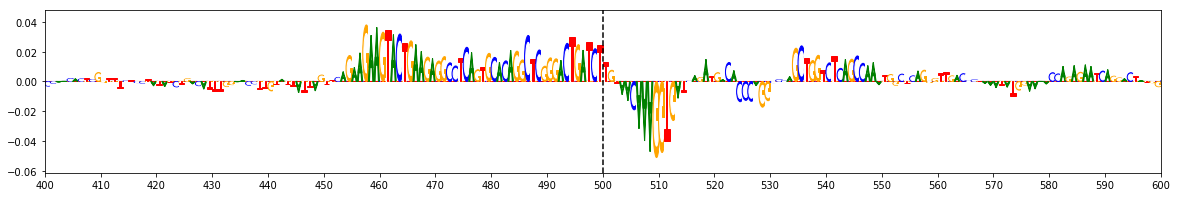

Index:  28  Importance:  0.6449537349000001  RSID:  rs10736701
Minor Allele:  C


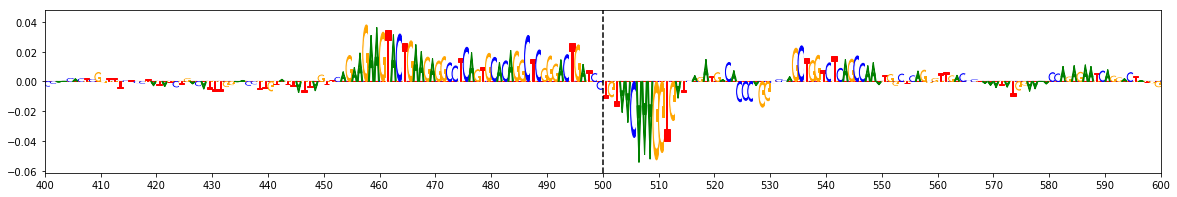

Index:  28  Delta:  -0.23241879710000002  RSID:  rs10736701
Minor - Major:  C - T


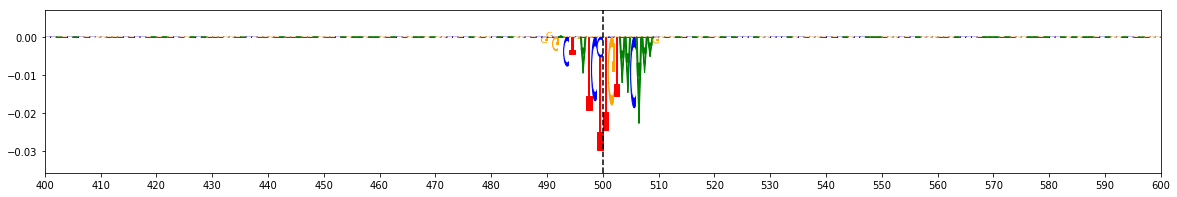

In [20]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Major Allele: ", gwas_major[idx])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [31]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head(10)

,index,chr,start,end,rsid,locus,major_allele,minor_allele,major_score,minor_score,delta
20,20,chr11,60019149,60019150,rs636317,149,T,C,1.656542,3.299272,1.642730
40,40,chr11,85867874,85867875,rs10792832,150,G,A,1.094689,1.470480,0.375790
17,17,chr11,59988861,59988862,rs584469,149,T,G,1.705030,2.043117,0.338087
39,39,chr11,85852978,85852979,rs10792831,150,A,G,2.363931,2.701221,0.337290
0,0,chr11,47398962,47398963,rs12146565,148,G,A,-0.392465,-0.069623,0.322842
1,1,chr11,47399601,47399602,rs2278890,148,G,A,0.433770,0.662054,0.228284
26,26,chr11,60031398,60031399,rs10736700,149,C,T,0.172574,0.367345,0.194772
3,3,chr11,47416635,47416636,rs55876153,148,G,C,0.170297,0.362318,0.192021
27,27,chr11,60031398,60031399,rs10736700,149,C,A,0.172574,0.356640,0.184066
7,7,chr11,47429903,47429904,rs7947450,148,G,A,3.067069,3.248758,0.181689


## Get 10 bp around SNP

In [32]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(minor_seqs[idx][490:510])
    print(minor_seqs[idx][490:500], '|', major_seqs[idx][500:510])

CTTTGCTGCCATCTGCTGGG
CTTTGCTGCC | ATCTGCTGGG
AAAATGTAGAAGCAAAACAT
AAAATGTAGA | AGCAAAACAT
CCCCATTCCGGCCACACTGC
CCCCATTCCG | GCCACACTGC
GGGGAACAGGAAGGTTGATC
GGGGAACAGG | AAGGTTGATC
GAAAAGGGAAAAGGGTCCTT
GAAAAGGGAA | AAGGGTCCTT


## Visualize Top Sequences

Index:  20  Importance:  1.6565424143  RSID:  rs636317 chr11 :  60019149  -  60019150  Locus:  149
Minor Allele:  C


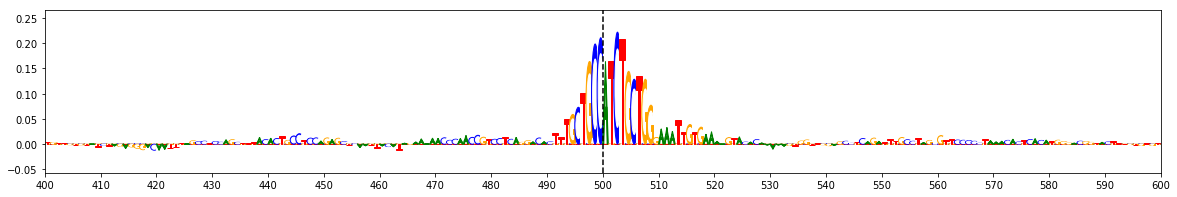

Index:  20  Importance:  1.6565424143  RSID:  rs636317
Major Allele:  T


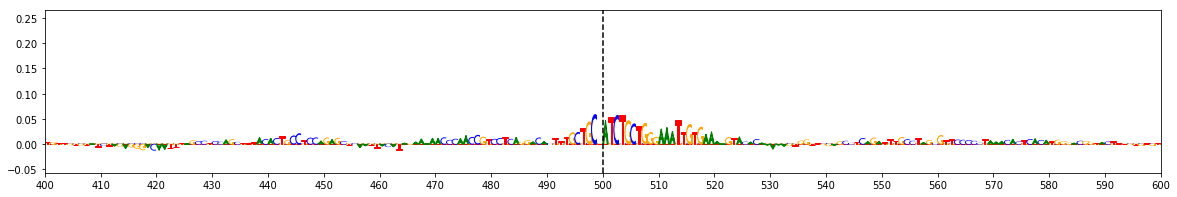

Index:  20  Delta:  1.6427298736999996  RSID:  rs636317
Minor - Major:  C - T


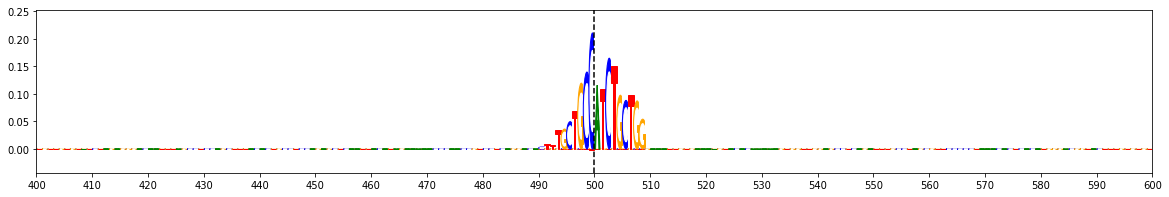

Index:  40  Importance:  1.0946893402  RSID:  rs10792832 chr11 :  85867874  -  85867875  Locus:  150
Minor Allele:  A


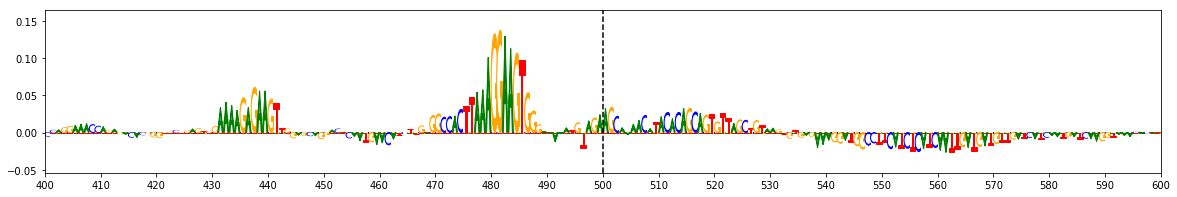

Index:  40  Importance:  1.0946893402  RSID:  rs10792832
Major Allele:  G


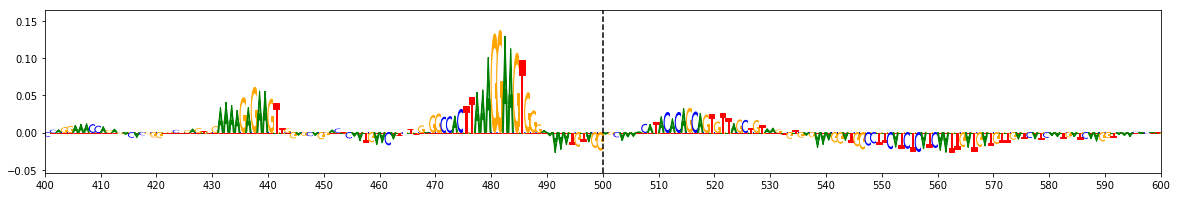

Index:  40  Delta:  0.3757902812  RSID:  rs10792832
Minor - Major:  A - G


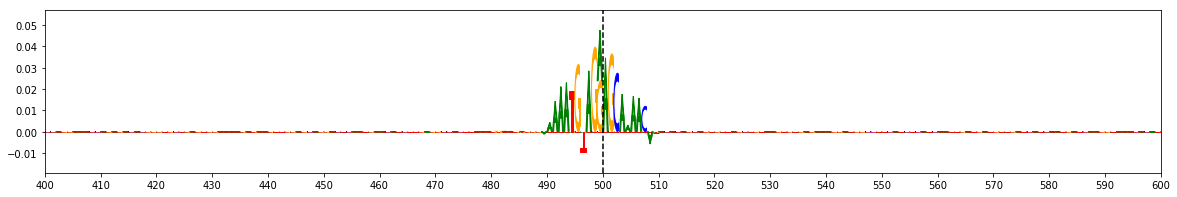

Index:  17  Importance:  1.7050295674000002  RSID:  rs584469 chr11 :  59988861  -  59988862  Locus:  149
Minor Allele:  G


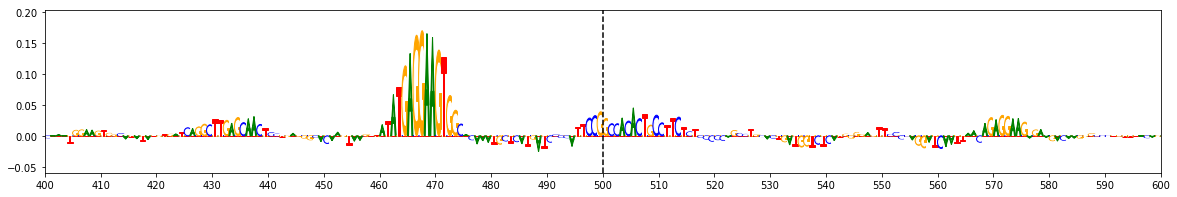

Index:  17  Importance:  1.7050295674000002  RSID:  rs584469
Major Allele:  T


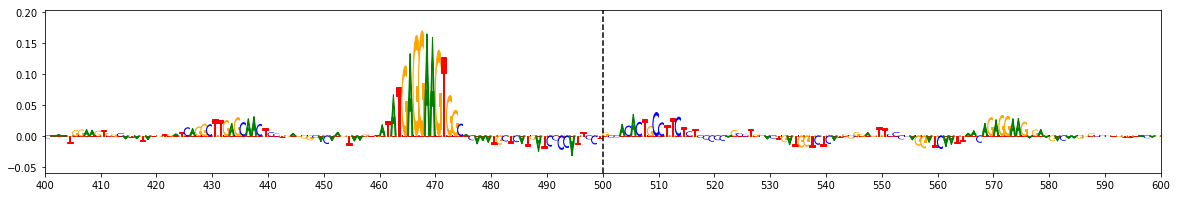

Index:  17  Delta:  0.3380872598999993  RSID:  rs584469
Minor - Major:  G - T


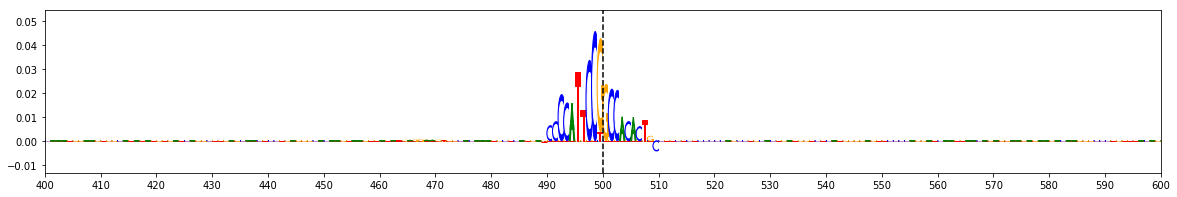

Index:  39  Importance:  2.3639307448  RSID:  rs10792831 chr11 :  85852978  -  85852979  Locus:  150
Minor Allele:  G


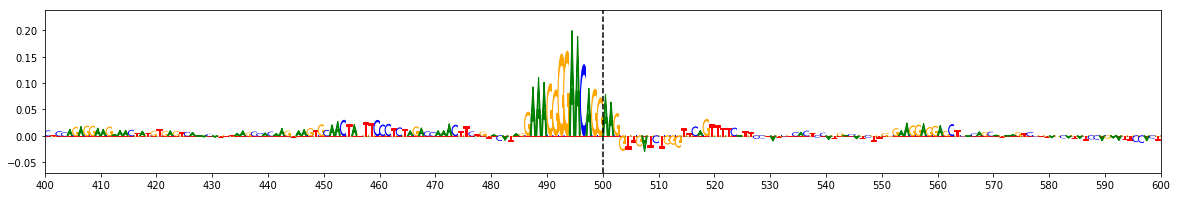

Index:  39  Importance:  2.3639307448  RSID:  rs10792831
Major Allele:  A


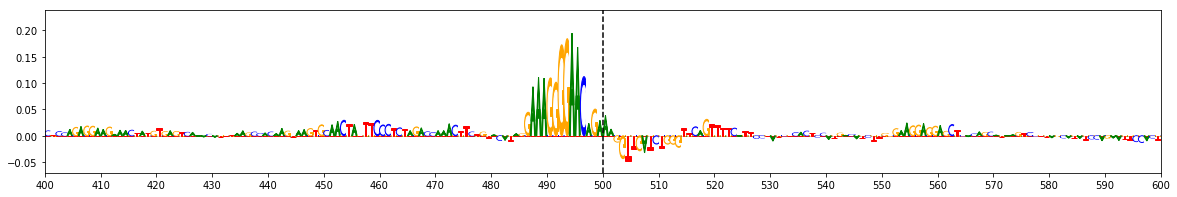

Index:  39  Delta:  0.3372900018999996  RSID:  rs10792831
Minor - Major:  G - A


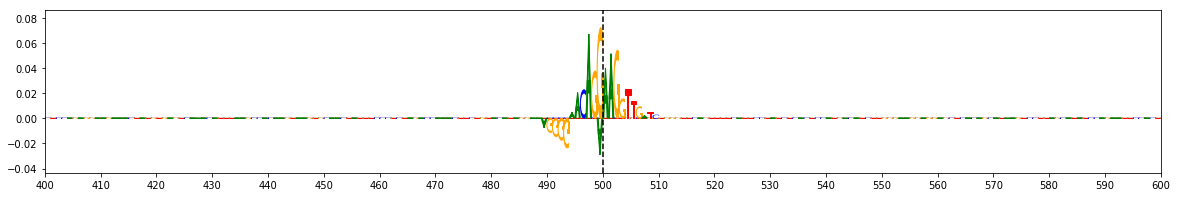

Index:  0  Importance:  -0.39246520100000004  RSID:  rs12146565 chr11 :  47398962  -  47398963  Locus:  148
Minor Allele:  A


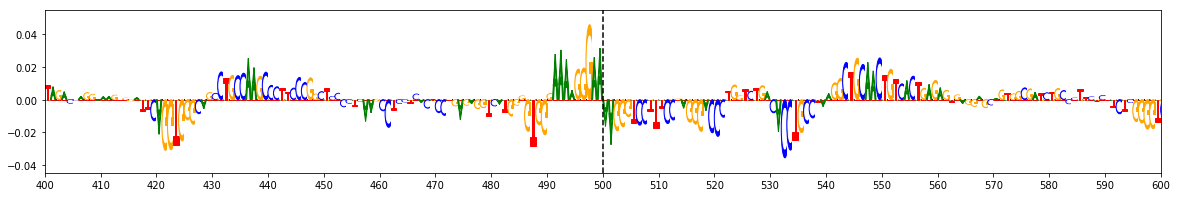

Index:  0  Importance:  -0.39246520100000004  RSID:  rs12146565
Major Allele:  G


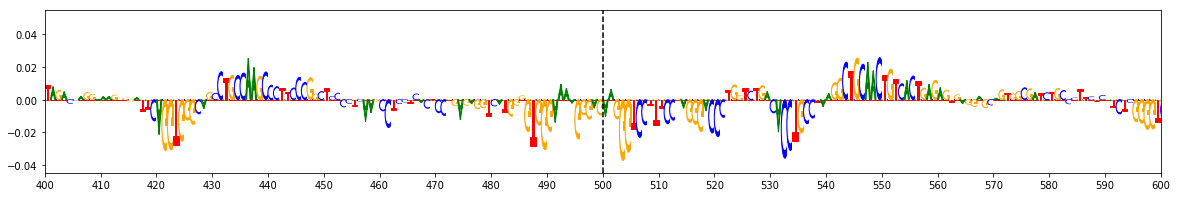

Index:  0  Delta:  0.322842067  RSID:  rs12146565
Minor - Major:  A - G


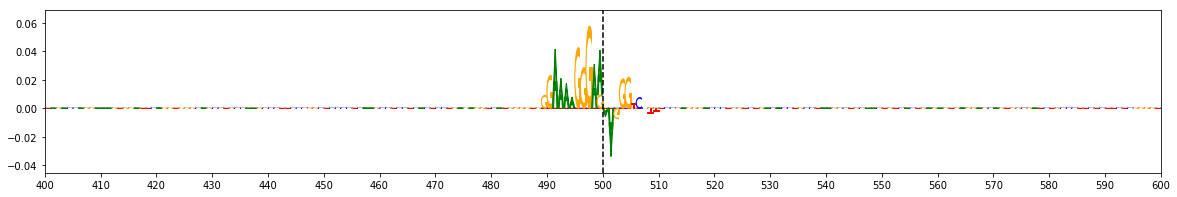

In [33]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'], " Locus: ", seq_df.at[idx, 'locus'])
    print("Minor Allele: ", gwas_minor[idx])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Minor - Major: ", gwas_minor[idx] + ' - ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))